In [36]:
FRAME_RATE = 2.5

In [37]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Process the data and convert it into a pandas DataFrame
def get_df_from_file(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            values = line.strip().split()
            frame = float(values[0])
            pedestrian_id = float(values[1])
            x = float(values[-4])
            y = float(values[-2])
            data.append([frame, pedestrian_id, x, y])

    df = pd.DataFrame(data, columns=["frame", "pedestrian_id", "x", "y"])
    return df
gt_path = 'frame_data.txt'
preds_path = 'preds.txt'
gt_df = get_df_from_file(gt_path)
preds_df = get_df_from_file(preds_path)

,frame,pedestrian_id,x,y
0,0.0,1.0,5.577136,3.434354
1,0.0,2.0,6.186022,-2.343108
2,1.0,1.0,5.672341,3.290679
3,1.0,2.0,6.306365,-2.096824
4,1.0,3.0,6.133517,-1.640965
...,...,...,...,...
101,39.0,2.0,13.197391,2.549966
102,39.0,6.0,13.416729,-1.089389
103,40.0,1.0,13.158268,-1.065854
104,40.0,2.0,13.351326,2.506863


In [38]:
# # add one to x in df to create fake preds for testing
# fake_preds_df = df.copy()
# fake_preds_df["x"] = fake_preds_df["x"] + 1
# # only select frames 8-19 inclusive
# fake_preds_df = fake_preds_df[(fake_preds_df["frame"] >= 8) & (fake_preds_df["frame"] <= 19)]
# # only include pedestrian 1 and 2
# fake_preds_df = fake_preds_df[(fake_preds_df["pedestrian_id"] == 1) | (fake_preds_df["pedestrian_id"] == 2)]
# # save fake preds as csv
# fake_preds_df.to_csv('fake_preds.csv', index=False)


In [40]:
# filter gt_df to only include pedestrian ids that are in fake_preds_df
gt_df = gt_df[gt_df["pedestrian_id"].isin(preds_df["pedestrian_id"])]
# convert gt_df pedestrian_id to ints
gt_df["pedestrian_id"] = gt_df["pedestrian_id"].astype(int)
gt_df['pedestrian_id'] = gt_df['pedestrian_id'].astype(str)
# convert gt_df pedestrian_id to string
gt_df["pedestrian_id"].unique()

array(['1', '2'], dtype=object)

In [41]:
# add a preds_ infront of every pedestrian_id in fake_preds_df
preds_df['pedestrian_id'] = 'preds_' + preds_df['pedestrian_id'].astype(str)
# combine the two dataframes
df = pd.concat([preds_df, gt_df])
# sort by frame and pedestrian_i
df['pedestrian_id'].unique()
display(df)

,frame,pedestrian_id,x,y
27,8.0,preds_1.0,7.707582,2.407746
28,8.0,preds_2.0,8.781538,-1.434450
31,9.0,preds_1.0,7.926228,2.430234
32,9.0,preds_2.0,9.128983,-1.397506
33,10.0,preds_1.0,8.154029,2.481739
...,...,...,...,...
99,38.0,2,12.962277,2.572406
100,39.0,1,12.968055,-1.152088
101,39.0,2,13.197391,2.549966
103,40.0,1,13.158268,-1.065854


In [42]:
# add a new pid 0 to each frame in df with x,y = 0,0 representing the center of the frame
center = pd.DataFrame([[frame, 0, 0, 0] for frame in df["frame"].unique()], columns=["frame", "pedestrian_id", "x", "y"])
df = pd.concat([df, center])

In [43]:
# CREATE VIDEO USING OUR VIDEO FRAMES
import os
import cv2
# Set the path to the directory containing the images
image_dir = 'parallel/'
prefix = 'color'
# Get the sorted list of image files
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')])
# every image is in format 'color{frame}.jpg'
# reorder the image files to match the order of the frames in the dataframe
# create dictionary of frame number to image file
image_files = {int(f.split(prefix)[1].split('.')[0])-1: f for f in image_files}

# Create a video writer to save the video frames
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
first_image = cv2.imread(os.path.join(image_dir, image_files[0]))
video_writer = cv2.VideoWriter('video.mp4', fourcc, FRAME_RATE, (first_image.shape[1], first_image.shape[0]))

# Write the video frames to the video writer
for frame in sorted(df['frame'].unique()):
    image_file = image_files[frame]
    img = cv2.imread(os.path.join(image_dir, image_file))
    video_writer.write(img)

video_writer.release()

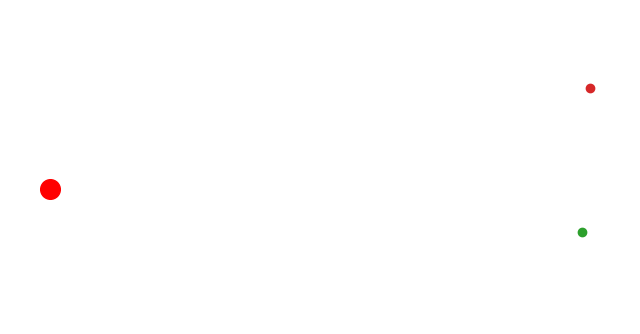

In [44]:
# CREATE TOP DOWN VISUALIZATIONS OF THE TRAJECTORIES AND SAVE AS GIF
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


# Create a figure and axis for the trajectory plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(df['x'].min()-1, df['x'].max()+1)
ax.set_ylim(df['y'].min()-1, df['y'].max()+1)
ax.set_aspect('equal')
ax.axis('off')

# Create empty lists to store the scatter plots
scatters = []

# Add a large point at (0, 0)
origin_point = ax.scatter(0, 0, s=200, color='red', marker='o', zorder=3)
scatters.append(origin_point)

# Initialize the scatter plots for each pedestrian_id
for pid in df['pedestrian_id'].unique():
    scat = ax.scatter([], [], label=f'Pedestrian {pid}')
    scatters.append(scat)

# Update function for the animation
def update(frame):
    # Update the trajectory plot
    for scat, pid in zip(scatters[1:], df['pedestrian_id'].unique()):
        mask = (df['frame'] == frame) & (df['pedestrian_id'] == pid)
        scat.set_offsets(df.loc[mask, ['x', 'y']].values)
    
    # # Display the corresponding image
    # if frame < len(image_files):
    #     img = cv2.imread(os.path.join(image_dir, image_files[frame]))
    #     ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #     ax2.axis('off')

    
    # # Save the current frame as an image
    # plt.savefig(f'end_results/combined_frame_{int(frame)}.png', bbox_inches='tight')
    
    return scatters

# Create the animation
ani = FuncAnimation(fig, update, frames=sorted(df['frame'].unique()), blit=True, interval=100)

# Save the animation as a video file using PillowWriter
writer = PillowWriter(fps=FRAME_RATE)
ani.save("trajectory_animation.gif", writer=writer)
# Close the video window

In [ ]:
# PLOTS LINES INSTEAD OF SCATTER PLOTS
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation, PillowWriter

# ...

# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.set_xlim(df['x'].min()-1, df['x'].max()+1)
# ax.set_ylim(df['y'].min()-1, df['y'].max()+1)
# ax.set_aspect('equal')
# ax.axis('off')

# # Create empty lists to store the line objects
# lines = []

# # Initialize the line objects for each pedestrian_id
# for pid in df['pedestrian_id'].unique():
#     line, = ax.plot([], [], '-', linewidth=2, label=f'Pedestrian {int(pid)}')
#     lines.append(line)

# # Update function for the animation
# def update(frame):
#     for line, pid in zip(lines, df['pedestrian_id'].unique()):
#         mask = (df['frame'] <= frame) & (df['pedestrian_id'] == pid)
#         line.set_data(df.loc[mask, 'x'], df.loc[mask, 'y'])
#     return lines

# # Create the animation
# ani = FuncAnimation(fig, update, frames=df['frame'].max()+1, blit=True, interval=100)

# # Save the animation as a GIF file using PillowWriter
# writer = PillowWriter(fps=10)
# ani.save('trajectory_animation.gif', writer=writer)

# # Display the plot
# plt.legend()
# plt.show()

In [45]:
# COMBINE THE GIF AND VIDEO INTO A SINGLE VIDEO
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Read the trajectory animation GIF
gif = cv2.VideoCapture('trajectory_animation.gif')

# Get the video frames
video = cv2.VideoCapture('video.mp4')

# Get the video frame size
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a video writer for the combined video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
combined_writer = cv2.VideoWriter('combined_video.mp4', fourcc, FRAME_RATE, (video_width * 2, video_height))

while True:
    # Read frames from the GIF and video
    ret_gif, frame_gif = gif.read()
    ret_video, frame_video = video.read()

    if not ret_gif or not ret_video:
        break

    # Resize the GIF frame to match the video frame size
    frame_gif = cv2.resize(frame_gif, (video_width, video_height))

    # Combine the GIF and video frames side by side
    combined_frame = np.concatenate((frame_gif, frame_video), axis=1)

    # Write the combined frame to the video writer
    combined_writer.write(combined_frame)

# Release the video capture and writer objects
gif.release()
video.release()
combined_writer.release()